The purpose of this tutorial is to segmentend individual ISS cells, to predict the cell type of ISS cells and to impute the expression of genes that were not included in the original gene panel. For this we'll use a pre-trained segmentation algorithm and Tangram to impute the gene expression.

This notebook was created by Sergio Marco (sergiomarco.salas@scilifelab.se) and was partially adapted from Tangram tutorials, create dy Tommaso Biancalani <biancalt@gene.com>

## Loading the packages needed

We need a couple of extra packages, so we will download them using

In [1]:
!pip install scikit-image>0.19 --upgrade
!pip install cellpose

The first step is to import the packages that will be used through the tutorial.

In [2]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import seaborn as sns
import pandas as pd
import urllib
import tangram as tg

We will use some customized functions. For this purpose we need to download a couple of libraries and import them. This functions will allow us to segment individual cells and assign reads to cells

In [3]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/Moldia/ISS_postprocessing/master/ISS_postprocessing/segmentation.py','./segmentation.py' )
urllib.request.urlretrieve('https://raw.githubusercontent.com/Moldia/ISS_postprocessing/master/ISS_postprocessing/annotated_objects.py','./annotated_objects.py' )
import segmentation as segmentation
import annotated_objects as annotated_objects

# Segment individual cells 

In previous steps, we have decoded an ISS dataset and, at this point, we should have a .csv containing the location and identity of every read decoded in the tissue. Together with this, we have a reference DAPI staining (stored as a .tif image) that can be used to identify the nuclei of the cells present in the section analyed. The first step is, then, to load and segment the nuclei so that we can identify individual cells

In [4]:
impath='../data/in_situ_sequencing/background.jpg'

In [5]:
im=plt.imread(impath)

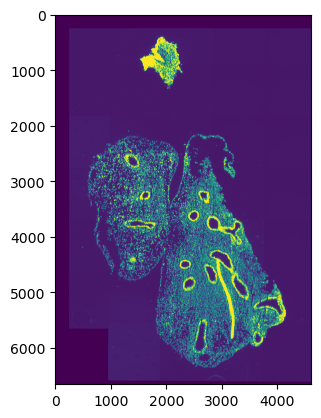

In [6]:
plt.imshow(im)

We segment individual cells using Cell Pose (with pretrained segmentation model) and we'll save the segmentation mask as a .npz file, where the identity of every segmented cell is stored. Since nuclei do not represent the entire cells ,but just the central part of it, we will expand the segmentation masks to include as a part of the cells an are of n pixels arround every detected cell

In [7]:
coo_matrix=segmentation.cell_pose_segemenation_to_coo(im, 10, 10)

We plot the location of the cells with the customized function. In this case, since we used a low quality jpg image, the segmentation doesn't work perfectly. In a real case we would use a .tif as an input instead and we'd modify the segmentation parameters. 

In [8]:
def plot_coo_matrix(m):
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='black')
    ax.plot(m.col, m.row, 's', color='white', ms=0.01)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

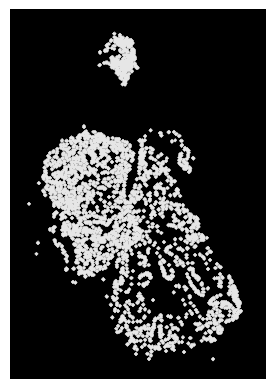

In [9]:
ax = plot_coo_matrix(coo_matrix[1])
ax.figure.show()

The output of the segmentation is a coo matrix (sparse matrix) and  will be stored as a npz file. 

In [10]:
segmentation_path='../data/in_situ_sequencing/'
scp.sparse.save_npz(segmentation_path+'stardist_segmentation_expanded.npz',coo_matrix[1])

We need to read the csv containing the spots location and change the column names so that it fits the customized function to assign reads to cells. Since the image we used for segmentation was resized to half of the original size (so that we can run the tutorial in a reasonable time), we need to also adjust the XY positions. Therefore, we will divide them by 2 as well.

In [15]:
spots=pd.read_csv('../data/in_situ_sequencing/S2T1_pcw6.csv')
spots.columns=['target','yc','xc','Q','parentCell']
spots['xc']=spots['xc']/2
spots['yc']=spots['yc']/2
spots.to_csv('../data/in_situ_sequencing/S2T1_pcw6_formatted.csv')

We want to make sure that the cell masks match with the position of the reads

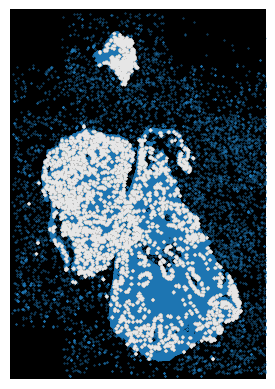

In [16]:
ax = plot_coo_matrix(coo_matrix[1])
ax.figure.show()
plt.scatter(spots['xc'],spots['yc'],s=0.1)

After this, we'll couple the segmentation mask we've just obtained with the .csv file that contains the decoded spots, so that we can assign every individual spots to the cells they belong to, based on the segmentation mask. We will store the output of the segmenatation in an annotated data object (anndata), keeping the expression of every cell as well as the position of its centroid

In [17]:
adata_sp = annotated_objects.create_anndata_obj(spots_file = '../data/in_situ_sequencing/S2T1_pcw6_formatted.csv', 
            segmentation_mask = segmentation_path+'stardist_segmentation_expanded.npz',#'cell_segmentation/cellpose_segmentation_expanded_2.npz' 
            output_file = '../data/in_situ_sequencing/anndata_cellpose.h5ad',
            filter_data=False, 
            metric = 'distance', 
            write_h5ad = True,
            value=  0.4,
            convert_coords = True, 
            conversion_factor = 1)

reading spots file
load coo file
assign spots to cells
write h5ad


We want to filter out cells with very little number of reads assigned.

In [21]:
sc.pp.filter_cells(adata_sp, min_counts=3)

We can now save the anndata object

In [22]:
adata_sp.write('../data/in_situ_sequencing/segmented_ISS.h5ad')

In [35]:
adata_sp=sc.read('../data/in_situ_sequencing/segmented_ISS.h5ad')

At this point, we can plot the expression of a certain gene in every cell in the space using the recently created anndata object

In [43]:
adata_sp.obsm["spatial"]=np.array([adata_sp.obs.x,adata_sp.obs.y]).transpose().astype('float64')

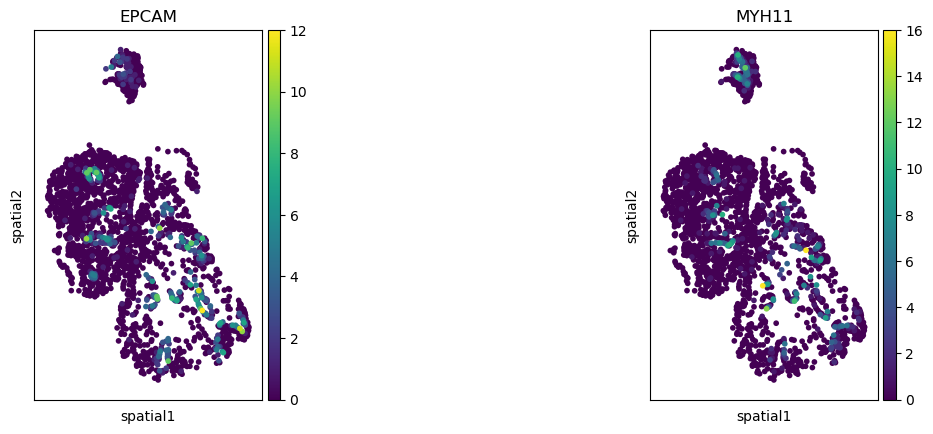

In [51]:
sc.pl.spatial(adata_sp,color=["EPCAM",'MYH11'],spot_size=100)

# Reading scRNAseq dataset 

We first read the scRNAseq dataset that we will integrate with our spatial (ISS) dataset. It's important that both datasets represent the same tissue/patient, since these integration methods assume that the cell type composition in the spatial dataset and the scRNAseq dataset are comparable.

In [52]:
adata_sc=sc.read('../results/single_cell/single_cell_qc_int_dr_cl.h5ad')

 Here, we only do some light pre-processing as library size correction (in scanpy, via `sc.pp.normalize`) to normalize the number of count within each cell to a fixed number. Sometimes, we apply more sophisticated pre-processing methods, for example for batch correction, although mapping works great with raw data. Ideally, the single cell and spatial datasets, should exhibit signals as similar as possible and the pre-processing pipeline should be finalized to harmonize the signals.

In [54]:
sc.pp.normalize_total(adata_sp)

It is a good idea to have annotations in the single cell data, as they will be projected on space after we map. In this case, clusters are annotated in leiden and louvain terms, in .obs. We will use  `leiden_1.2` field from now. 

Tangram learns a spatial alignment of the single cell data so that  _the gene expression of the aligned single cell data is as similar as possible to that of the spatial data. In doing this, Tangram only looks at a subset genes, specified by the user, called the training genes.
- The choice of the training genes is a delicate step for mapping: they need to bear interesting signals and to be measured with high quality.
- For untargeted methods such as ST, a good start is to choose 100-1000 top marker genes, evenly stratified across cell types. In ISS experiements like these, where genes were selected for being good markers of different cell types, we can use all the genes that presented a reasonable expression

## Preparing the datasets

We now need to prepare the datasets for mapping: the two `AnnData` structures need to be subset on the list of training genes. First, we build a list of marker genes present at the spatial anndata object which are also present in the scRNAseq anndata object. 


In [55]:
markers=np.unique(adata_sp.var.index[adata_sp.var.index.isin(adata_sp.var.index)])
len(markers)

142

Since we want to keep information about the expression of other genes detected in scRNAseq, we save this information in .raw

In [56]:
adata_sc.raw=adata_sc

Also, the gene order needs to be the same in the datasets. This is because Tangram maps using only gene expression, so the $j$-th column in each matrix must correspond to the same gene.And if data entries of a gene are all zero, this gene will be removed.This task is performed by the helper `pp_adatas`.

In [57]:
tg.pp_adatas(adata_sc, adata_sp,genes=None)

INFO:root:141 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:141 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


Ideally, at this point we'd like to save the adata objects and potentially restart the kernel

In [58]:
adata_sc.write_h5ad('../data/in_situ_sequencing/ad_sc_readytomap.h5ad')
adata_sp.write_h5ad('../data/in_situ_sequencing/ad_sp_readytomap.h5ad')

# Mapping cells to space

If we have restarted the kernel or if we want to continue from this point, we need to import the packages again

In [59]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch
import tangram as tg

We now read the anndata objects that we just saved on the previous step (in case we need to read it)

In [68]:
ad_sp = sc.read_h5ad('../data/in_situ_sequencing/ad_sp_readytomap.h5ad')
ad_sc = sc.read_h5ad('../data/in_situ_sequencing/ad_sc_readytomap.h5ad')

We can now train the model (_ie_ map the single cell data onto space).
- Mapping should be interrupted after the score plateaus,which can be controlled by passing the `num_epochs` parameter. 
- The score measures the similarity between the gene expression of the mapped cells vs spatial data: higher score means better mapping
- Note that we obtained excellent mapping even if Tangram converges to a low scores (the typical case is when the spatial data are very sparse): we use the score merely to assess convergence.
- If you are running Tangram with a GPU, uncomment `device=cuda:0` and comment the line `device=cpu`. On a MacBook Pro 2018, it takes ~1h to run. On a P100 GPU it should be done in a few minutes.
- For this basic mapping, we do not use regularizers. More sophisticated loss functions can be used using the Tangram library (refer to manuscript or dive into the code).
- We can map at cluster-level single cell data instead of cell level data (refer to manuscript or dive into the code), which is faster and requires less memory. In this notebook, we are mapping at individual cell level.

In [71]:
ad_map = tg.map_cells_to_space( ad_sc, ad_sp, device='cpu',num_epochs=500)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 141 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: -0.044, KL reg: 0.000
Score: 0.941, KL reg: 0.000
Score: 0.943, KL reg: 0.000
Score: 0.944, KL reg: 0.000
Score: 0.945, KL reg: 0.000


INFO:root:Saving results..


The mapping results are stored in the returned `AnnData` structure, saved as `ad_map`, structured as following:

  - The cell-by-spot matrix `X` contains the probability of cell $i$ to be in spot $j$.
  - The `obs` dataframe contains the metadata of the single cells.
  - The `var` dataframe contains the metadata of the spatial data.
  - The `uns` dictionary contains a dataframe with various information about the training genes (saved ad `train_genes_df`).
  
  
  We can also plot some quality scores that can give us an overview of the quality of our integration
    


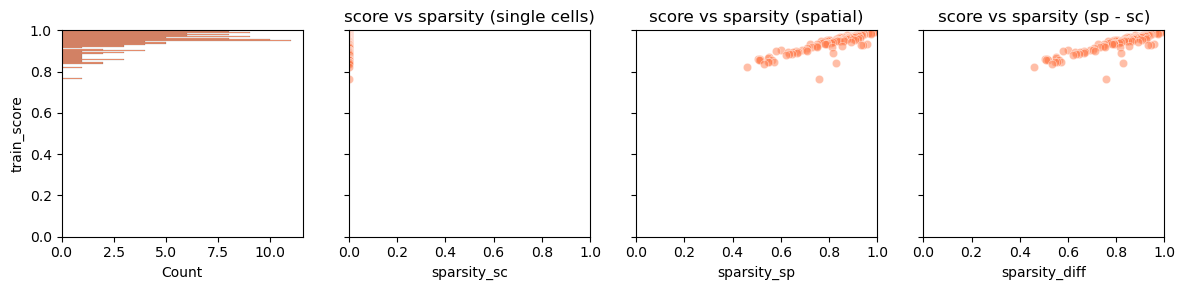

In [72]:
tg.plot_training_scores(ad_map, bins=50, alpha=.5)

- Although the above plots give us a summary of scores at single-gene level, we would need to know _which_ are the genes are mapped with low scores.
- These information can be access from the dataframe `.uns['train_genes_df']` from the mapping results; this is the dataframe used to build the four plots above.

In [73]:
ad_map.uns['train_genes_df']

,train_score,sparsity_sc,sparsity_sp,sparsity_diff
wnt2b,0.999294,0.0,0.998327,0.998327
cdon,0.998852,0.0,0.997072,0.997072
wnt2,0.997633,0.0,0.989962,0.989962
tcf7l1,0.997590,0.0,0.987035,0.987035
phox2b,0.995582,0.0,0.989962,0.989962
...,...,...,...,...
upk3b,0.844200,0.0,0.546215,0.546215
nkg7,0.840656,0.0,0.828524,0.828524
wnt11,0.839156,0.0,0.531995,0.531995
notch2,0.820191,0.0,0.458804,0.458804


We can now save the mapping results for post-analysis.

In [74]:
ad_map.write_h5ad('../data/in_situ_sequencing/ad_map.h5ad')

# Exploring the cell type annotation

In [75]:
ad_map=sc.read_h5ad('../data/in_situ_sequencing/ad_map.h5ad')

Tangram can be used to project cell type annotations (from scRNAseq) into the space by giving a probability to each cell capture with ISS to belong to a specific cell type (ie. cell typing). Thus, we can plot the cell type identity into space to explore their location

In [76]:
ad_map

AnnData object with n_obs × n_vars = 24875 × 2391
    obs: 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'louvain_0.4', 'leiden_0.4', 'louvain_0.6', 'leiden_0.6', 'louvain_0.8', 'leiden_0.8', 'louvain_0.9', 'leiden_0.9', 'louvain_1.0', 'leiden_1.0', 'louvain_1.1', 'leiden_1.1', 'louvain_1.2', 'leiden_1.2', 'louvain_1.4', 'leiden_1.4', 'louvain_1.6', 'leiden_1.6'
    var: 'x', 'y', 'area', 'n_counts', 'uniform_density', 'rna_count_based_density'
    uns: 'train_genes_df', 'training_history'

In [77]:
ad_sp

AnnData object with n_obs × n_vars = 2391 × 142
    obs: 'x', 'y', 'area', 'n_counts', 'uniform_density', 'rna_count_based_density'
    var: 'n_cells', 'sparsity'
    uns: 'overlap_genes', 'training_genes'
    obsm: 'spatial'

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


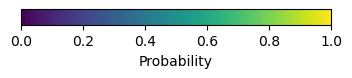

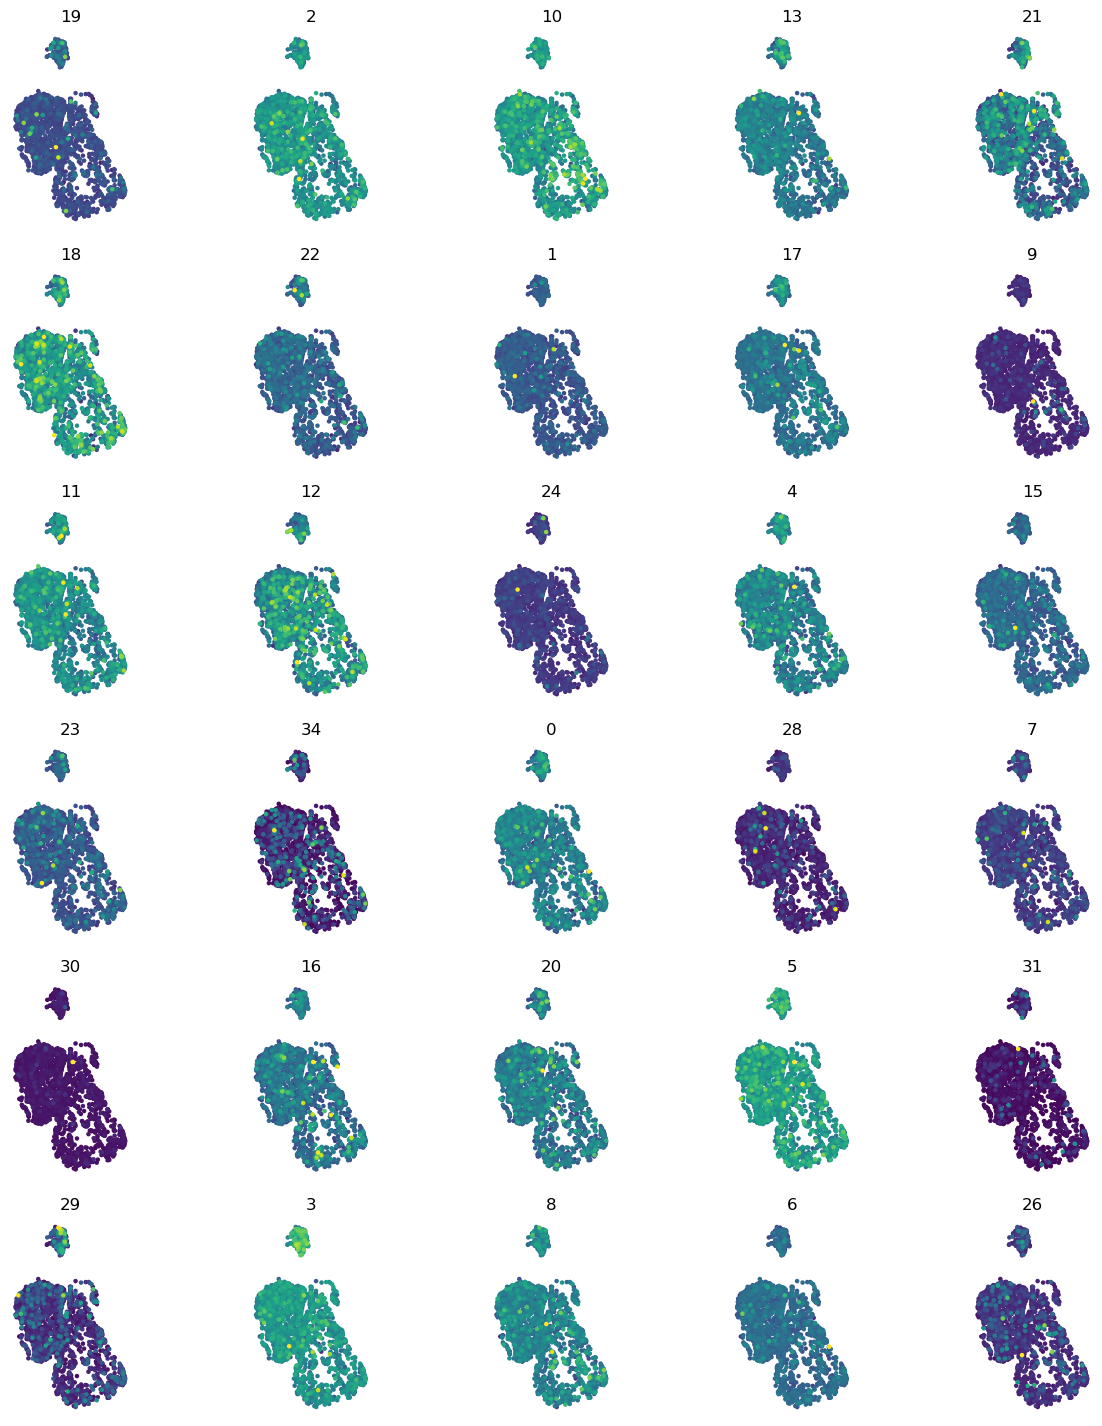

In [78]:
tg.plot_cell_annotation(ad_map,ad_sp, annotation='leiden_1.2', nrows=6, ncols=5)

# Imputing the expression of genes into space

With Tangram, since the datasets from both modalities are integrated, we can impute the expression of genes not included in the ISS panel, but present in the scRNAseq dataset. This is done by averaging the expression of the scRNAseq cells found to be similar to each ISS cell after training. To obtain this expression patterns, we first need to compute:

In [79]:
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=ad_sc)

With `project genes` we generate a new anndata object containing the imputed expression of each scRNAseq gene in space. Remember to use the .raw expression from the `ad_sc` object, since these object contains the expression of all genes, instead of only the common ones

It is convenient to compute the similarity scores of all genes, which can be done by `compare_spatial_geneexp`. This function accepts two spatial `AnnData`s (_ie_ voxel-by-gene), and returns a dataframe with simlarity scores for all genes. Training genes are flagged by the Boolean field `is_training`.

In [80]:
df_all_genes = tg.compare_spatial_geneexp(ad_ge, ad_sp)
df_all_genes

,score,is_training,sparsity_sp
wnt2b,0.999294,True,0.998327
cdon,0.998852,True,0.997072
wnt2,0.997633,True,0.989962
tcf7l1,0.997590,True,0.987035
phox2b,0.995582,True,0.989962
...,...,...,...
upk3b,0.844200,True,0.546215
nkg7,0.840656,True,0.828524
wnt11,0.839156,True,0.531995
notch2,0.820191,True,0.458804


We can plot the scores of the test genes and see how they compare to the training genes. Following the strategy in the previous plots, we visualize the scores as a function of the sparsity of the spatial data.

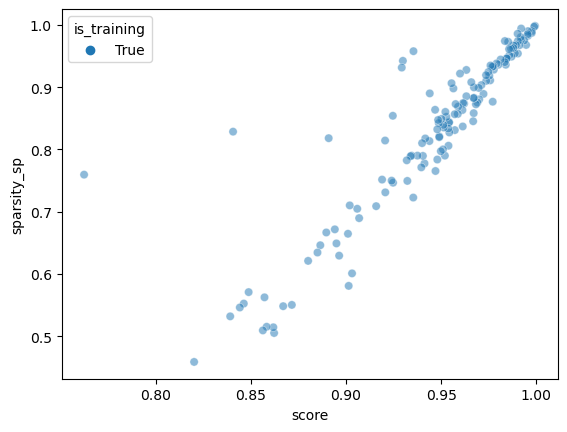

In [81]:
sns.scatterplot(data=df_all_genes, x='score', y='sparsity_sp', hue='is_training', alpha=.5);

Usually sparser genes in the spatial data are predicted with low scores, which is due to the presence of dropouts in the spatial data.
- Let's choose a few test genes with varied scores and compared predictions vs measured gene expression.

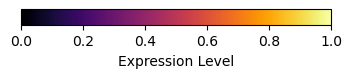

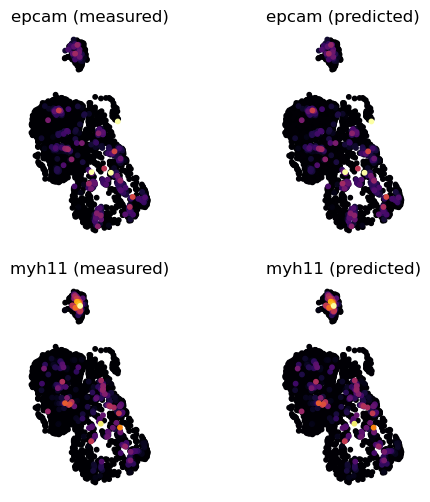

In [82]:
genes=['epcam','myh11']
tg.plot_genes(genes, adata_measured=ad_sp, adata_predicted=ad_ge,s=10)